In [470]:
# %%
import os,argparse,natsort
import pandas as pd
import matplotlib.pyplot as plt
# display more columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [471]:
data_dir = '/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/'

In [472]:

def generate_summary_stats_per_op(data_dir):

    root_to_files = {}
    for root, dirs, files in os.walk(data_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    config_to_stats = {}

    # recursively find all the log files
    for root in roots:
        if 'e2e' in root:
            continue
        files = root_to_files[root]
        print(root)

        # root is in the format of /mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b1024_gpu4
        # get me the batch size and gpu count as 'b1024_gpu4
        root = root.rstrip('/')
        batch_size_gpu_count = root.split('/')[-1]

        combine_df = pd.DataFrame()
        for file in files:
            if 'worker_pid' in file:
                fp = os.path.join(root, file)
                #  read the log file as csv with no header
                df = pd.read_csv(fp, header=None)
                df.columns = ["name", "start", "dur"]

                # drop columns with name "start"
                df = df.drop(columns=["start"])

                # divide "dur" column by 1000,000 to get time in ms
                df["dur"] = df["dur"] / 1000000
                # discard the rows with name starting with SBatch
                df = df[~df["name"].str.startswith("SBatch")]

                # concatenate all the dataframes
                combine_df = pd.concat([combine_df, df])

        # check if the dataframe is empty
        if combine_df.empty:
            continue

        stats_df = combine_df.groupby("name").agg(["sum"])

        # make the column names flat
        stats_df.columns = stats_df.columns.get_level_values(0)
        config_to_stats[batch_size_gpu_count] = stats_df
    
    return config_to_stats

        

In [473]:
# %%
print("All numbers are in ms")
config_to_stats = generate_summary_stats_per_op(data_dir)

All numbers are in ms
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu1
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu3
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu4
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu1
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu3
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu4
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b512_gpu1
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b512_gpu2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b512_gpu3
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b512_gpu4
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b1024_gpu2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b1024_gpu3
/mydata/pytorch_custom_lo

In [474]:
# concat all the stats into one dataframe make keys a columns with name "config"
all_stats_df = pd.concat(config_to_stats).reset_index() 

In [475]:
all_stats_df.head(10)

,level_0,name,dur
0,b128_gpu1,SCollation,4.981761e+05
1,b128_gpu1,SLoader,6.013031e+06
2,b128_gpu1,SNormalize,2.709073e+05
3,b128_gpu1,SRandomHorizontalFlip,7.456310e+04
4,b128_gpu1,SRandomResizedCrop,1.335576e+06
5,b128_gpu1,SToTensor,4.055524e+05
6,b128_gpu1,STransform,2.239575e+06
7,b128_gpu2,SCollation,4.862332e+05
8,b128_gpu2,SLoader,5.976696e+06
9,b128_gpu2,SNormalize,2.684417e+05


In [476]:
# replace the column name "level_0" with "config"
all_stats_df = all_stats_df.rename(columns={"level_0": "config"})
# replace the column name "dur" with "E2E elapsed time (ms)"
all_stats_df = all_stats_df.rename(columns={"dur": "E2E elapsed time (secs)"})
# replace the column name "name" with "Function"
all_stats_df = all_stats_df.rename(columns={"name": "Function"})

In [477]:
# remove column 'name' with 'STransform' 
all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("STransform")]
# remove column 'name' with 'SCollation'
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("SCollation")]
# remove SLoader
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("SLoader")]

In [478]:
all_stats_df.head(10)

,config,Function,E2E elapsed time (secs)
0,b128_gpu1,SCollation,4.981761e+05
1,b128_gpu1,SLoader,6.013031e+06
2,b128_gpu1,SNormalize,2.709073e+05
3,b128_gpu1,SRandomHorizontalFlip,7.456310e+04
4,b128_gpu1,SRandomResizedCrop,1.335576e+06
5,b128_gpu1,SToTensor,4.055524e+05
7,b128_gpu2,SCollation,4.862332e+05
8,b128_gpu2,SLoader,5.976696e+06
9,b128_gpu2,SNormalize,2.684417e+05
10,b128_gpu2,SRandomHorizontalFlip,7.395954e+04


In [479]:
# divide the column "E2E elapsed time (ms)" by 1000 to get time in seconds
all_stats_df["E2E elapsed time (secs)"] = all_stats_df["E2E elapsed time (secs)"] / 1000

In [480]:
print(all_stats_df.columns)

Index(['config', 'Function', 'E2E elapsed time (secs)'], dtype='object')


In [481]:
all_stats_df.head(len(all_stats_df))

,config,Function,E2E elapsed time (secs)
0,b128_gpu1,SCollation,498.176080
1,b128_gpu1,SLoader,6013.031317
2,b128_gpu1,SNormalize,270.907338
3,b128_gpu1,SRandomHorizontalFlip,74.563096
4,b128_gpu1,SRandomResizedCrop,1335.576147
...,...,...,...
99,b1024_gpu4,SLoader,6102.529089
100,b1024_gpu4,SNormalize,279.387387
101,b1024_gpu4,SRandomHorizontalFlip,79.188754
102,b1024_gpu4,SRandomResizedCrop,1427.239707


In [482]:
want_max_diff = False

In [483]:
if want_max_diff:
    # get sum of 'E2E elapsed time (secs)' for each config
    tmp = all_stats_df.groupby('config')['E2E elapsed time (secs)'].sum().sort_values(ascending=False)
    # get the first index of tmp
    max_config = tmp.index[0]
    min_config = tmp.index[-1]
    #  print max config and min config along with the difference
    print("Max config: {}, Min config: {}, \nDifference in elapsed time: {:.2f} seconds".format(max_config, min_config, tmp[max_config] - tmp[min_config]))
    config1 = max_config
    config2 = min_config
else:
    batch_size1 = 1024
    batch_size2 = 256
    gpus1 = 4
    gpus2 = 1

    config1 = f'b{batch_size1}_gpu{gpus1}'
    config2 = f'b{batch_size2}_gpu{gpus2}'

In [484]:
tmp

config
b1024_gpu4    8866.219474
b512_gpu4     8751.948099
b128_gpu1     8597.806373
b128_gpu2     8548.998246
b256_gpu1     8532.622086
b1024_gpu3    8529.868489
b256_gpu4     8527.945643
b128_gpu3     8484.605650
b128_gpu4     8465.779304
b512_gpu3     8460.111700
b1024_gpu2    8447.141026
b512_gpu1     8419.379733
b256_gpu3     8400.338896
b512_gpu2     8399.875955
b256_gpu2     8375.323485
Name: E2E elapsed time (secs), dtype: float64

In [492]:
# pretty print the difference in elapsed time
print("Difference in elapsed time {} - {} : {:.3f} seconds".format(config1,config2, tmp[config1] - tmp[config2]))

Difference in elapsed time b1024_gpu4 - b256_gpu1 : 333.597 seconds


In [499]:
# get difference of the functions' 'E2E elapsed time (secs)' between config1 and config2
diff_df = all_stats_df[all_stats_df["config"].isin([config1, config2])].groupby(["Function", "config"]).agg(["sum"]).reset_index()
print(diff_df.head(len(diff_df)))
diff_df.columns = diff_df.columns.get_level_values(0)
diff_df["diff"] = diff_df.groupby("Function")["E2E elapsed time (secs)"].diff()
diff_df = diff_df.dropna()
diff_df = diff_df.sort_values(by=["diff"], ascending=False)
# drop column config and 'E2E elapsed time (secs)'
diff_df = diff_df.drop(columns=["config", "E2E elapsed time (secs)"])
# pretty print the difference in elapsed time
print("Difference in elapsed time {} and {} across functions".format(config1,config2))
print(diff_df.head(len(diff_df)))

                 Function      config E2E elapsed time (secs)
                                                          sum
0              SCollation  b1024_gpu4              541.174733
1              SCollation   b256_gpu1              504.760826
2                 SLoader  b1024_gpu4             6102.529089
3                 SLoader   b256_gpu1             5954.846601
4              SNormalize  b1024_gpu4              279.387387
5              SNormalize   b256_gpu1              267.607072
6   SRandomHorizontalFlip  b1024_gpu4               79.188754
7   SRandomHorizontalFlip   b256_gpu1               74.269004
8      SRandomResizedCrop  b1024_gpu4             1427.239707
9      SRandomResizedCrop   b256_gpu1             1330.534272
10              SToTensor  b1024_gpu4              436.699804
11              SToTensor   b256_gpu1              400.604312
Difference in elapsed time b1024_gpu4 and b256_gpu1 across functions
                 Function        diff
7   SRandomHorizontalFlip

In [486]:
# only keep cofngi values with config 'b256_gpu2' and '1024_gpu4' in all_stats_df
all_stats_df_filtered = all_stats_df[all_stats_df['config'].isin([config1, config2])]

In [487]:
all_stats_df_filtered.head(len(all_stats_df_filtered))

,config,Function,E2E elapsed time (secs)
28,b256_gpu1,SCollation,504.760826
29,b256_gpu1,SLoader,5954.846601
30,b256_gpu1,SNormalize,267.607072
31,b256_gpu1,SRandomHorizontalFlip,74.269004
32,b256_gpu1,SRandomResizedCrop,1330.534272
33,b256_gpu1,SToTensor,400.604312
98,b1024_gpu4,SCollation,541.174733
99,b1024_gpu4,SLoader,6102.529089
100,b1024_gpu4,SNormalize,279.387387
101,b1024_gpu4,SRandomHorizontalFlip,79.188754


In [488]:
# pivot table with config as index and name as columns and E2E elapsed time (ms) as values
pivot_df = all_stats_df_filtered.pivot_table(index='config', columns='Function', values='E2E elapsed time (secs)')

In [489]:
# do a natsort over the config column
pivot_df = pivot_df.reindex(natsort.natsorted(pivot_df.index))

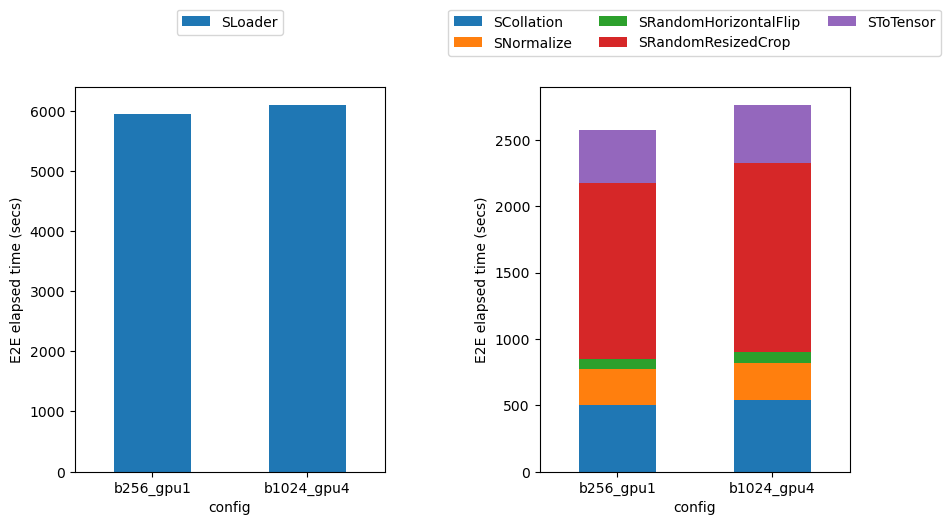

In [490]:
# get dataframe with function 'SLoader' only
pivot_df_SLoader = pivot_df[['SLoader']]

# get dataframe with all functions except 'SLoader' without dropping the 'SLoader' column
pivot_df_without_SLoader = pivot_df.drop(columns=['SLoader'])

# generate a subplot with above two figures
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pivot_df_SLoader.plot(kind='bar', ax=axes[0])
pivot_df_without_SLoader.plot(kind='bar', stacked=True, ax=axes[1])

# squeeze figsize of first subplot horizontally
fig.subplots_adjust(wspace=0.5)

# display legends at the top of each subplot
axes[0].legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0.)
# make legend of second subplot outside the plot at the top and make it horizontal
axes[1].legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0., ncol=3)

# set y label for first subplot
axes[0].set_ylabel('E2E elapsed time (secs)')
# set y label for second subplot
axes[1].set_ylabel('E2E elapsed time (secs)')
# set x label for first subplot
axes[0].set_xlabel('config')
# set x label for second subplot
axes[1].set_xlabel('config')

# make x axis labels horizontal for all subplots
for ax in axes:
    ax.tick_params(axis='x', labelrotation=0)
plt.show()

